sample_data/     test_labels.csv   train_labels.csv
test_inputs.csv  train_inputs.csv


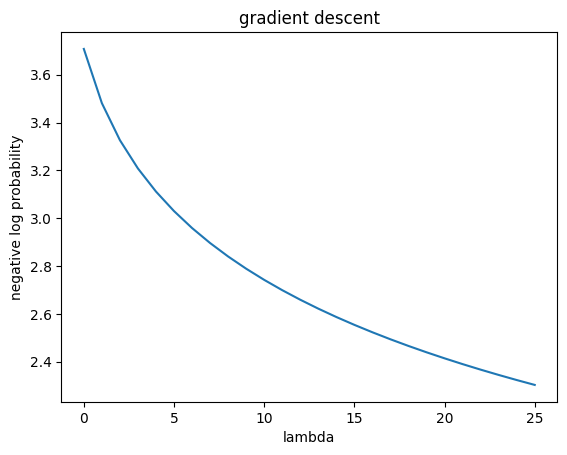

Gradient descent best lambda: 25
Gradient descent best cross validation negative log probability: 2.303261925101862
Gradient descent test accuracy: 0.8818181818181818
Gradient descent test negative log probability: 1.9368158664622683
Gradient descent # of iterations: 1408


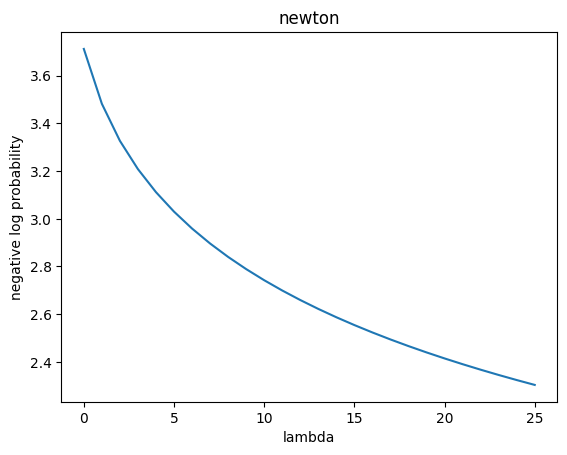

Newton best lambda: 25
Newton best cross validation negative log probability: 2.3032344370887103
Newton test accuracy: 0.8818181818181818
Newton test negative log probability: 1.9369695670577094
Newton # of iterations: 5


In [14]:
from google.colab import files
uploaded = files.upload()
%ls

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def load_logistic_regression_data():
  test_inputs = np.genfromtxt('test_inputs.csv', delimiter=',')
  test_labels = np.genfromtxt('test_labels.csv', delimiter=',')
  train_inputs = np.genfromtxt('train_inputs.csv', delimiter=',')
  train_labels = np.genfromtxt('train_labels.csv', delimiter=',')
  return train_inputs, train_labels, test_inputs, test_labels

def sigmoid(input):
  output = 1 / (1 + np.exp(-input))
  return output

def predict_logistic_regression(inputs, weights):
  predicted_probabilities = np.zeros((inputs.shape[0],2))
  for i in range(inputs.shape[0]):
    predicted_probabilities[i,0] = 1 - sigmoid(np.dot(inputs[i,:],weights))
    predicted_probabilities[i,1] = sigmoid(np.dot(inputs[i,:],weights))
  return predicted_probabilities

def eval_logistic_regression(inputs, weights, labels):
  accuracy = 0
  neg_log_prob = 0
  predicted_probabilities = predict_logistic_regression(inputs, weights)
  for i in range(inputs.shape[0]):
    neg_log_prob += -labels[i] * np.log(predicted_probabilities[i,0]) - (1 - labels[i]) * np.log(predicted_probabilities[i,1])
    if predicted_probabilities[i,labels[i]] >= 0.5:
      accuracy += 1
  accuracy = accuracy / inputs.shape[0]
  neg_log_prob = neg_log_prob / inputs.shape[0]
  return neg_log_prob, accuracy

def initialize_weights(n_weights):
  random_weights = np.zeros(n_weights)
  for i in range(n_weights):
    random_weights[i] = np.random.uniform(-0.01,0.01)
  return random_weights

def train_logistic_regression_gradient(train_inputs, train_labels, lambda_hyperparam, max_iters=10000, gradient_norm_threshold=0.1, learning_rate=0.0001):
  weights = np.zeros(train_inputs.shape[1])
  weights = initialize_weights(train_inputs.shape[1])
  n_iters = 0
  gradient = np.ones(train_inputs.shape[1])
  while n_iters <= max_iters and np.linalg.norm(gradient) >= gradient_norm_threshold:
    gradient = train_inputs.T @ (sigmoid(train_inputs @ weights) - train_labels) + lambda_hyperparam * weights
    weights = weights - learning_rate * gradient
    n_iters += 1
  return weights, n_iters

def train_logistic_regression_newton(train_inputs, train_labels, lambda_hyperparam, max_iters=10000, gradient_norm_threshold=0.1):
  weights = np.zeros(train_inputs.shape[1])
  weights = initialize_weights(train_inputs.shape[1])
  n_iters = 0
  gradient = np.ones(train_inputs.shape[1])
  while n_iters <= max_iters and np.linalg.norm(gradient) >= gradient_norm_threshold:
    gradient = train_inputs.T @ (sigmoid(train_inputs @ weights) - train_labels) + lambda_hyperparam * weights
    diagonal = np.zeros(train_inputs.shape[0])
    for i in range(train_inputs.shape[0]):
      diagonal[i] = sigmoid(np.dot(train_inputs[i,:],weights)) * (1 - sigmoid(np.dot(train_inputs[i,:],weights)))
    hessian = train_inputs.T @ np.diag(diagonal) @ train_inputs + lambda_hyperparam * np.identity(train_inputs.shape[1])
    weights = weights - np.linalg.inv(hessian) @ gradient
    n_iters += 1
  return weights, n_iters

def cross_validation_logistic_regression(k_folds, hyperparameters, inputs, labels, algorithm):
  best_hyperparam = 0
  best_neg_log_prob = 0
  neg_log_probabilities = np.zeros(len(hyperparameters))
  for i in range(len(hyperparameters)):
    for j in range(k_folds):
      one_fold = int(len(inputs)/k_folds)
      validation_inputs = inputs[j*one_fold::one_fold]
      validation_labels = labels[j*one_fold::one_fold]
      if j == 0:
        train_inputs = inputs[(j+1)*one_fold:]
        train_labels = labels[(j+1)*one_fold:]
      elif j == k_folds-1:
        train_inputs = inputs[:j*one_fold]
        train_labels = labels[:j*one_fold]
      else:
        train_inputs = np.concatenate((inputs[:j*one_fold], inputs[(j+1)*one_fold:]))
        train_labels = np.concatenate((labels[:j*one_fold], labels[(j+1)*one_fold:]))
      if algorithm == 'gradient descent':
        weights, n_iters = train_logistic_regression_gradient(train_inputs, train_labels, hyperparameters[i])
      else:
        weights, n_iters = train_logistic_regression_newton(train_inputs, train_labels, hyperparameters[i])
      neg_log_prob, accuracy = eval_logistic_regression(validation_inputs, weights, validation_labels)
      neg_log_probabilities[i] += neg_log_prob
    neg_log_probabilities[i] = neg_log_probabilities[i] / k_folds
    if i == 0 or neg_log_probabilities[i] < best_neg_log_prob:
      best_neg_log_prob = neg_log_probabilities[i]
      best_hyperparam = hyperparameters[i]
  return best_hyperparam, best_neg_log_prob, neg_log_probabilities

def plot_logistic_regression_neg_log_probabilities(neg_log_probabilities,hyperparams,algorithm):
  plt.plot(hyperparams,neg_log_probabilities)
  plt.ylabel('negative log probability')
  plt.xlabel('lambda')
  plt.title(algorithm)
  plt.show()

# load data
train_inputs, train_labels, test_inputs, test_labels = load_logistic_regression_data()

# rescale inputs in the [-1,1] range
train_inputs = (train_inputs - 8)/8
test_inputs = (test_inputs - 8)/8

# add 1 at the end of each data point
train_inputs = np.concatenate((train_inputs,np.ones((train_inputs.shape[0],1))),1)
test_inputs = np.concatenate((test_inputs,np.ones((test_inputs.shape[0],1))),1)

# rename the classes 5,6 to 0,1
train_labels = train_labels.astype(int) - 5
test_labels = test_labels.astype(int) - 5

###############################################
# logistic regression based on gradient descent
###############################################

# lambda values to be evaluated by cross validation
hyperparams = range(26)
k_folds = 10
best_lambda, best_neg_log_prob, neg_log_probabilities = cross_validation_logistic_regression(k_folds,hyperparams,train_inputs,train_labels,'gradient descent')

# plot results
plot_logistic_regression_neg_log_probabilities(neg_log_probabilities,hyperparams,'gradient descent')
print('Gradient descent best lambda: ' + str(best_lambda))
print('Gradient descent best cross validation negative log probability: ' + str(best_neg_log_prob))

# train and evaluate with best lambda
weights, n_iters = train_logistic_regression_gradient(train_inputs,train_labels,best_lambda)
neg_log_prob, accuracy = eval_logistic_regression(test_inputs, weights, test_labels)
print('Gradient descent test accuracy: ' + str(accuracy))
print('Gradient descent test negative log probability: ' + str(neg_log_prob))
print('Gradient descent # of iterations: ' + str(n_iters))

#################################################
# logistic regression based on Newton's algorithm
#################################################

# lambda values to be evaluated by cross validation
hyperparams = range(26)
k_folds = 10
best_lambda, best_neg_log_prob, neg_log_probabilities = cross_validation_logistic_regression(k_folds,hyperparams,train_inputs,train_labels,'newton')

# plot results
plot_logistic_regression_neg_log_probabilities(neg_log_probabilities,hyperparams,'newton')
print('Newton best lambda: ' + str(best_lambda))
print('Newton best cross validation negative log probability: ' + str(best_neg_log_prob))

# train and evaluate with best lambda
weights, n_iters = train_logistic_regression_newton(train_inputs,train_labels,best_lambda)
neg_log_prob, accuracy = eval_logistic_regression(test_inputs, weights, test_labels)
print('Newton test accuracy: ' + str(accuracy))
print('Newton test negative log probability: ' + str(neg_log_prob))
print('Newton # of iterations: ' + str(n_iters))